### Import library

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score # SDB-CH

from sklearn.metrics import adjusted_rand_score # ARI
from sklearn.metrics import normalized_mutual_info_score # NMI
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score #


### Import dataset

In [68]:
dfHouse = pd.read_csv('House_Rent_Dataset.csv')

In [69]:
dfHouse.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


### Melihat bentukan dataset

In [70]:
dfHouse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


### Mengecek niali Null dan Duplikat pada dataset

In [71]:
print(dfHouse.isna().sum())
print("Duplicated data : ",dfHouse.duplicated().sum())

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64
Duplicated data :  0


### Menghapus outlier

In [72]:
dfHouse = dfHouse[(np.abs(stats.zscore(dfHouse.select_dtypes(['int64' , 'float64'])))<3).all(axis=1)]

### Preprocessing

In [73]:
# Scaling data numerik
mm_scaler = MinMaxScaler()
dfHouse[["BHK","Rent","Size","Bathroom"]] = mm_scaler.fit_transform(dfHouse[["BHK","Rent","Size","Bathroom"]])

# Menghapus column tanggal
dfHouse.drop(['Posted On'], axis=1, inplace=True)

# Encoding column Kategorikal
col=['Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Point of Contact', 'Tenant Preferred']
le=LabelEncoder()
for i in col:
    dfHouse[i]=le.fit_transform(dfHouse[i])

dfHouse.head(10)


,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,0.333333,0.034003,0.390681,415,2,217,4,2,1,0.333333,2
1,0.333333,0.072643,0.283154,14,2,1487,4,1,1,0.000000,2
2,0.333333,0.061051,0.354839,14,2,1714,4,1,1,0.000000,2
3,0.333333,0.034003,0.283154,10,2,514,4,2,1,0.000000,2
4,0.333333,0.024343,0.301075,10,1,1842,4,2,0,0.000000,2
5,0.333333,0.022411,0.211470,408,2,1925,4,2,1,0.333333,2
6,0.333333,0.034003,0.247312,418,2,1153,4,2,0,0.333333,0
7,0.000000,0.014683,0.086022,10,2,1153,4,2,0,0.000000,0
8,0.333333,0.095827,0.283154,10,1,1437,4,2,0,0.333333,0
9,0.333333,0.034003,0.354839,14,1,1321,4,1,1,0.333333,2


## A. Supervised Learning

### A1. Support Vector classifier

In [74]:
x = dfHouse[["Rent","Size"]] #feature
y = dfHouse["Tenant Preferred"] #target

# data split menjadi data train dan data test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# membuat model SVC dengan data train
svm = SVC(kernel='linear', class_weight='balanced')
svm.fit(x_train, y_train)

# prediksi data test
y_pred = svm.predict(x_test)

# menyimpan nilai support vector dan indexnya
support_vectors = svm.support_vectors_
support_vector_indices = np.where(np.isin(x_train, support_vectors).all(axis=1))

### A2. Evaluasi hasil

### Confusion matrix SVM

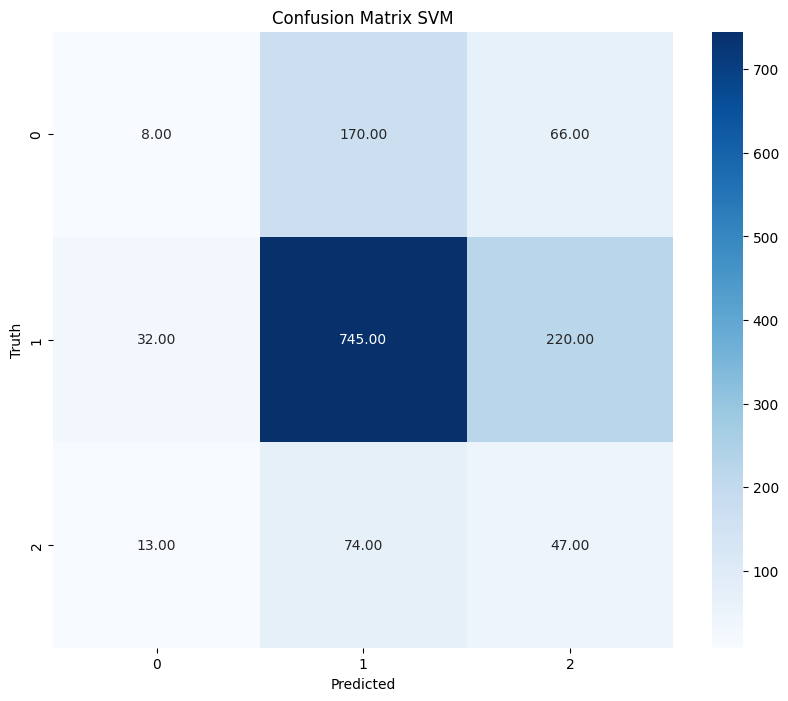

In [75]:
svm_cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(svm_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix SVM')
plt.show()

### Report Classification SVM

In [76]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.15      0.03      0.05       244
           1       0.75      0.75      0.75       997
           2       0.14      0.35      0.20       134

    accuracy                           0.58      1375
   macro avg       0.35      0.38      0.34      1375
weighted avg       0.59      0.58      0.57      1375



### A3. Plotting hasil prediksi SVM

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


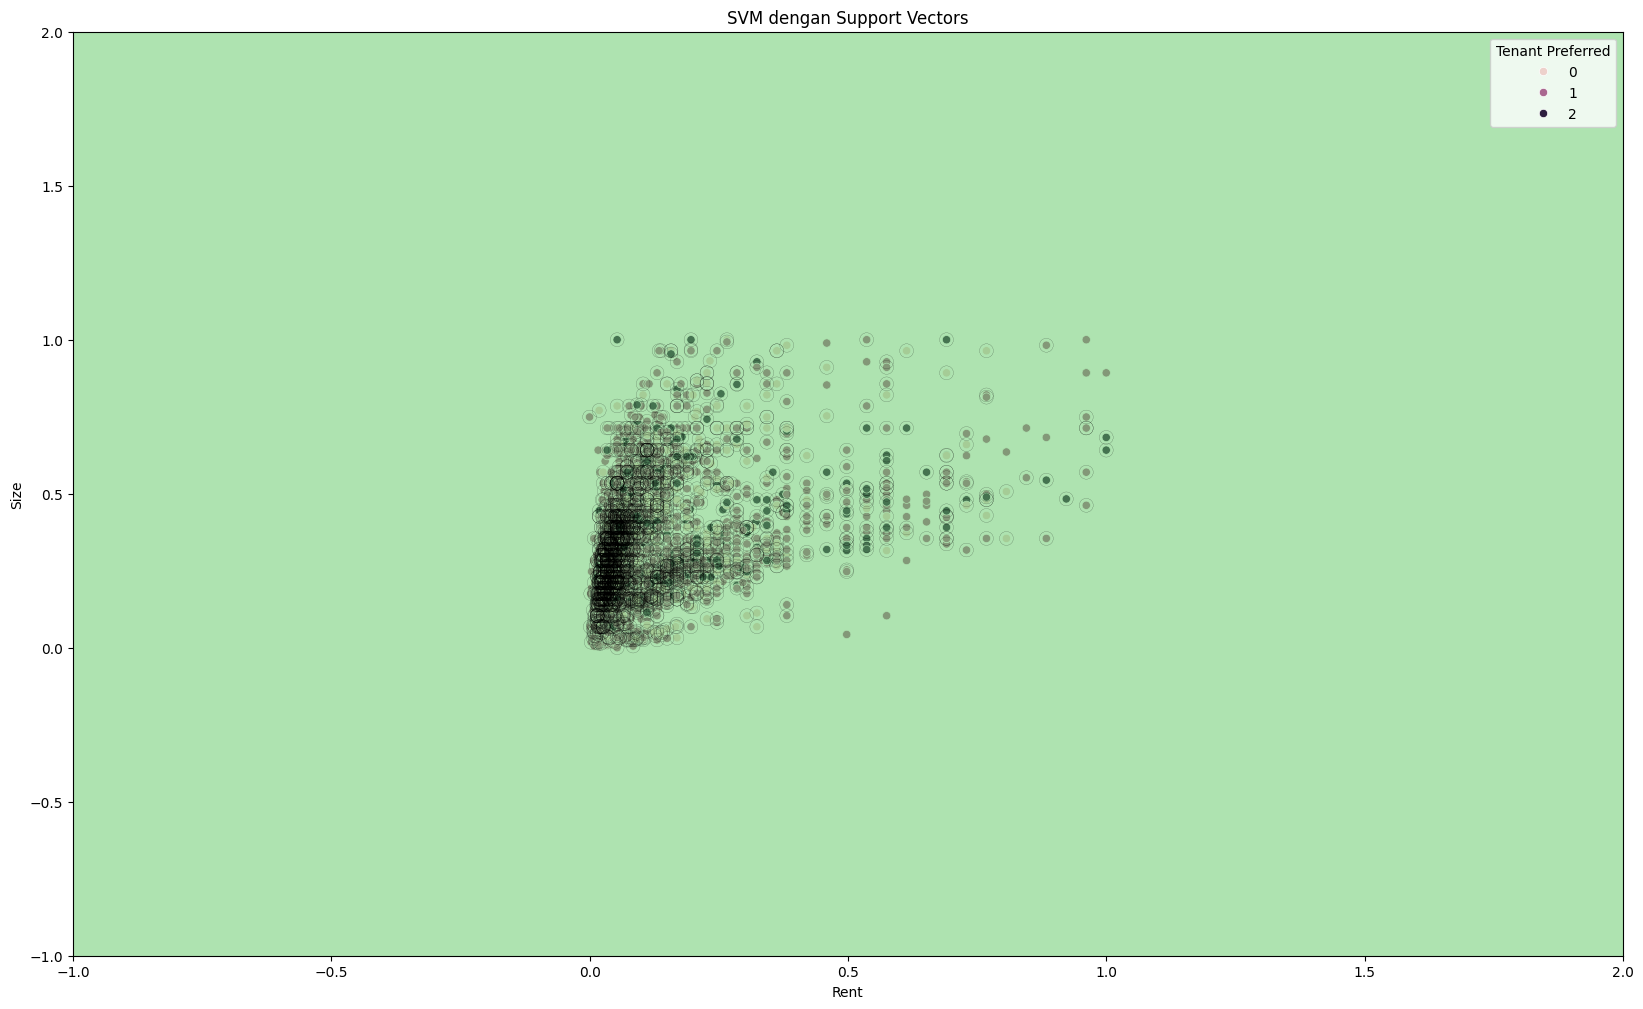

In [77]:

X = dfHouse[["Rent","Size"]]
y = dfHouse["Tenant Preferred"]

svm = SVC()
svm.fit(X, y)

plt.figure(figsize=(20, 12))
sns.scatterplot(x=dfHouse["Rent"], y=dfHouse["Size"], hue=dfHouse["Tenant Preferred"], data=dfHouse)

ax = plt.gca()

DecisionBoundaryDisplay.from_estimator(
    estimator=svm,
    X=X.values,  
    plot_method="contourf",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)

# Plot support vectors
ax.scatter(
    svm.support_vectors_[:, 0],
    svm.support_vectors_[:, 1],
    s=100,
    linewidth=0.1,
    facecolors="none",
    edgecolors="k",
)
plt.xlabel("Rent")
plt.ylabel("Size")
plt.title("SVM dengan Support Vectors")
plt.show()

### B. Unsupervised Learning

### B1. K-Means Clustering

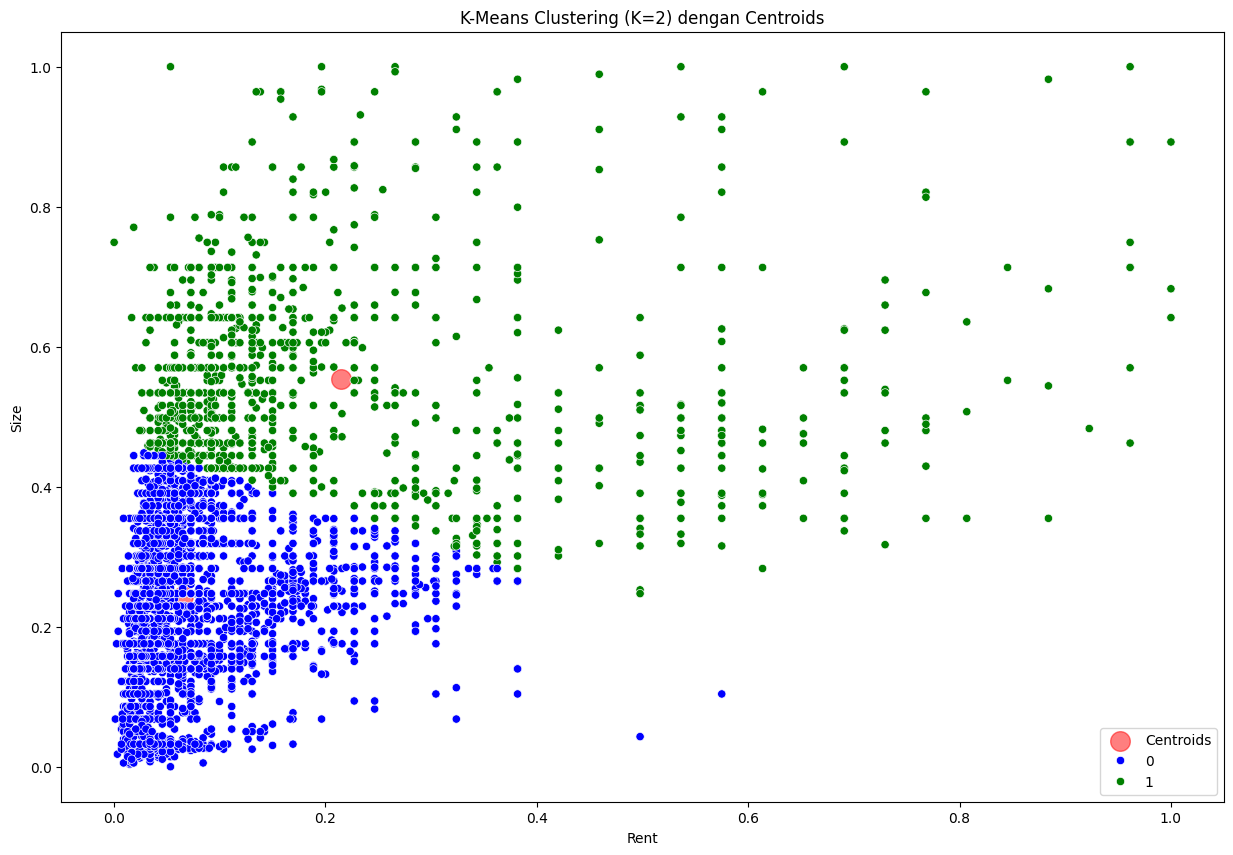

In [80]:
plt.figure(figsize=(15,10))

X = dfHouse[["Rent" , "Size" ]]
K =  2 # dari target

kmeans = KMeans(n_clusters=K, n_init=10) 
kmeans.fit(X) 
cluster_labels = kmeans.labels_ 
dfHouse["Tenant Preferred"] = cluster_labels 
centroids = kmeans.cluster_centers_ 
c = ["blue", "green"]
plt.scatter(centroids[:, 0], centroids[:, 1], alpha=0.5, c='red', s=200,label='Centroids')

sns.scatterplot(data=dfHouse, x=dfHouse['Rent'], y=dfHouse['Size'], hue="Tenant Preferred", palette=c)

plt.title(f"K-Means Clustering (K={K}) dengan Centroids")
plt.legend()
plt.show()

### B2. Evaluasi Hasil

### Tanpa label asli

In [81]:
# Silhouette Score
ss_score = silhouette_score(X, dfHouse['Tenant Preferred'])
print(f"Silhouette Score: {ss_score:.2f}")

# Davies-Bouldin Index
db_index = davies_bouldin_score(X, dfHouse['Tenant Preferred'])
print(f"Davies-Bouldin Index: {db_index:.2f}")

# Calinski-Harabasz Index
ch_index = calinski_harabasz_score(X, dfHouse['Tenant Preferred'])
print(f"Calinski-Harabasz Index: {ch_index:.2f}")

Silhouette Score: 0.52
Davies-Bouldin Index: 0.90
Calinski-Harabasz Index: 3915.20


### Dengan label asli

In [82]:
# Buat crosstab untuk membandingkan cluster labels dengan true labels
cross_tab = pd.crosstab(dfHouse["Tenant Preferred"], dfHouse["City"])
print("Cross-Tabulation:")
print(cross_tab, "\n")

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(dfHouse["City"], dfHouse['Tenant Preferred'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(dfHouse['City'], dfHouse['Tenant Preferred'])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

# Fungsi HCV-M
homogeneity = homogeneity_score(dfHouse["City"], dfHouse['Tenant Preferred'])
completeness = completeness_score(dfHouse["City"], dfHouse['Tenant Preferred'])
v_measure = v_measure_score(dfHouse["City"], dfHouse['Tenant Preferred'])
print(f"Homogeneity Score: {homogeneity:.2f}")
print(f"Completeness Score: {completeness:.2f}")
print(f"V-Measure Score: {v_measure:.2f}")


Cross-Tabulation:
City                0    1    2    3    4    5
Tenant Preferred                              
0                 682  672  473  543  465  647
1                 184  198  119  292   54  254 

Adjusted Rand Index (ARI): 0.00
Normalized Mutual Information (NMI): 0.01
Homogeneity Score: 0.01
Completeness Score: 0.03
V-Measure Score: 0.01


### B3. Plotting 

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=dfHouse, x="Rent", y="avg_price_per_room", hue="City", palette='Set2', marker="D", s=130, label="True Labels")
sns.scatterplot(data=dfHouse, x="Rent", y="avg_price_per_room", hue="cluster", palette='Set2', marker="o", s=40, label="Clusters")
plt.scatter(centroids[:, 0], centroids[:, 1], alpha=0.5, c='red', s=100, label='Centroids')
plt.title(f"K-Means Clustering (K={K}) dengan Centroids")
plt.xlabel("Lead Time")
plt.ylabel("Average Price per Room")
plt.legend(title="Legend", loc="upper right")
plt.show()